In [1]:
import sys
sys.path.append('../../moving-bar/')
if sys.platform == 'darwin':
    IS_MAC_1_OR_LINUX_0 = 1
else:
    IS_MAC_1_OR_LINUX_0 = 0

In [2]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager

import pandas as pd
import pickle
import copy

import lnk
import experiment
import analysis
import pyret.stimulustools as st
import pyret.filtertools as ft

%load_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 2.0]
#  plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
plt.rcParams['axes.linewidth'] = 0.7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3

In [4]:
def minmax(arr):
    arr = arr.copy()
    N = arr.shape[0]
    bs = (np.nanmean(arr[:int(N/200)]) + np.nanmean(arr[-int(N/200):]))/2
    arr -= bs
    #if abs(np.max(arr)) > abs(np.min(arr)):
    #    arr /= abs(np.max(arr))
    #else:
    #    arr /= abs(np.min(arr))
    arr /= abs(np.max(arr))
    return arr

def smooth_1d(mat, s=1):
    return scipy.ndimage.gaussian_filter1d(mat, s)

def fwhm_peak_mse(arr1, arr2):
    args11, args13 = arghalf(arr1)
    args12 = argmax(arr1)
    args21, args23 = arghalf(arr2)
    args22 = argmax(arr2)
    return arg_half_distance(np.array([args11, args12, args13]), np.array([args21, args22, args23]))

def argmax(arr):
    return int(np.where(arr==1)[0])

def arghalf(arr):
    arr_clip = np.clip(arr, 0.5, 1)
    arg_above = np.where(arr_clip > 0.5)[0]
    return int(arg_above[0]), int(arg_above[-1])

def arghalf_width(arr):
    arr_clip = np.clip(arr, 0.5, 1)
    arg_above = np.where(arr_clip > 0.5)[0]
    return int(arg_above[-1]) - int(arg_above[0])

def arg_half_distance(args1, args2):
    args_diff = args1 - args2
    return np.sqrt(np.sum(args_diff ** 2))

def hessian(x):
    x_grad = np.gradient(x)
    hess = np.zeros((x.ndim, x.ndim) + x.shape, dtype=x.dtype)
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k)
        for l, grad_kl in enumerate(tmp_grad):
            hess[k, l, :, :] = grad_kl
    return hess

In [5]:
l = {}
l['X'] = {}
l['y'] = {}

In [6]:
if IS_MAC_1_OR_LINUX_0:
    HOME = '/Users'
else:
    HOME = '/home'

In [7]:
with open(HOME + '/dlee/moving-bar/data-figure/ex_210214.p', 'rb') as f:
    ex = pickle.load(f)
with open(HOME + '/dlee/moving-bar/data-figure/df_210214.p', 'rb') as f2:
    df = pickle.load(f2)
with open(HOME + '/dlee/moving-bar/data-figure/bootstrap_c01.p', 'rb') as f3:
    re = pickle.load(f3)
    l['sample'] = re['sample']
    l['attrs'] = re['attrs']
    del re

In [8]:
ex.i.keys()

dict_keys(['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m', 'line', 'rf_5m', 'mb', 'flash_2', 'mb_ad_ao'])

In [9]:
idx_i = df.iloc[l['attrs']['g_list']]['exp_id'].unique()
idx_i

array([ 3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 16, 17])

In [10]:
cen_i_idx2_mb_l_for_i = np.round((2150/129)*df['cen_i_idx2'].unique()/2).astype(int)
cen_i_idx2_mb_r_for_i = np.round(-(2150/129)*df['cen_i_idx2'].unique()/2).astype(int)
l['X']['mb_cen_i_1ms'] = np.stack([analysis.mb_roll(analysis.i_downsample(ex.i['mb'][i][:, None, :, :], 2150), 
                                                    (cen_i_idx2_mb_l_for_i[i], cen_i_idx2_mb_r_for_i[i]), pad_mode='edge') 
                                   for i in idx_i])
l['X']['mb_cen_i_1ms'].shape

(12, 2, 1, 20, 2150)

In [11]:
l['X']['mb_cen_i_1ms_mean_raw'] = np.nanmean(l['X']['mb_cen_i_1ms'], (0, 1, 2, 3))
l['X']['mb_cen_i_1ms_mean'] = smooth_1d(l['X']['mb_cen_i_1ms_mean_raw'], 5) #2
l['X']['mb_cen_i_1ms_mean_mm'] = minmax(l['X']['mb_cen_i_1ms_mean'])
l['X']['mb_cen_i_1ms_mean_mm_10tile'] = np.tile(l['X']['mb_cen_i_1ms_mean_mm'], 10)

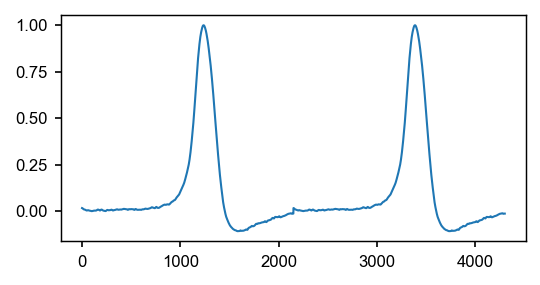

In [12]:
plt.plot(l['X']['mb_cen_i_1ms_mean_mm_10tile'][:2150+2150])

In [13]:
l['y']['s_2'] = smooth_1d(np.nanmean(l['sample']['gmtr']['c']['all']['diff'], 1), 1.5) #1.5
l['y']['s_2_1ms'] = smooth_1d(scipy.signal.resample(l['y']['s_2'], 2150), 5)
l['y']['s_2_1ms_mm'] = minmax(l['y']['s_2_1ms'])

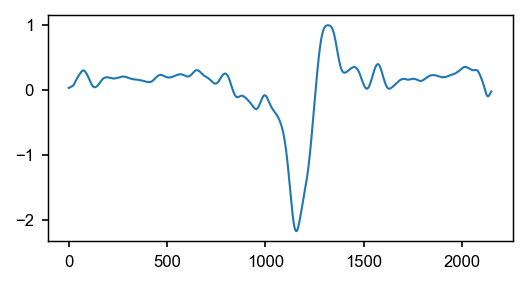

In [14]:
plt.plot(l['y']['s_2_1ms_mm'])

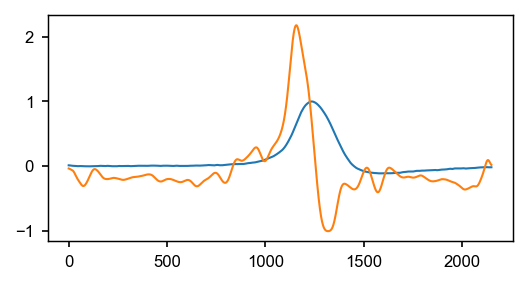

In [15]:
plt.plot(l['X']['mb_cen_i_1ms_mean_mm_10tile'][:2150])
#plt.plot(minmax(smooth_1d(np.diff(l['X']['mb_cen_i_1ms_mean_mm_10tile'][:2150])[:-1], 3.5)))
plt.plot(-l['y']['s_2_1ms_mm'])

In [16]:
u = l['X']['mb_cen_i_1ms_mean_mm_10tile']

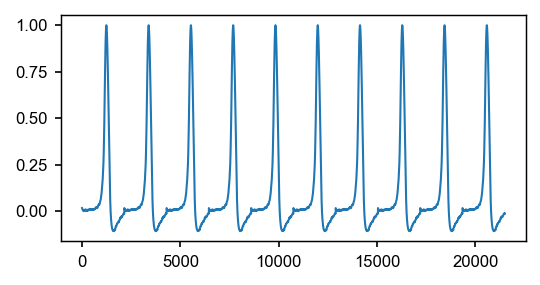

In [17]:
plt.plot(u)

## (v1) With New nonlinearity & Kinetics block parameters

In [19]:
uln, uln2 = lnk.simulate_nonlinearity(u, [2.5458*7.9474, -0.7199+0.1053, 2.1938+0, 0.0087*1, 0.1241-0.105])
out = lnk.simulate_4state(uln, uln2, [0, 9.8902*50, 0, 62.9771/50, 0, 6.1664/50], [0.1,0,0.4,0.5])

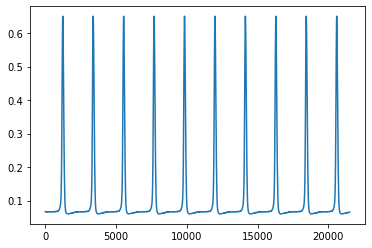

In [20]:
#plt.plot(uln)
plt.plot(uln2)

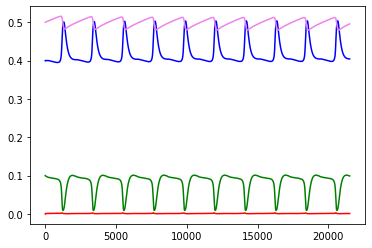

In [21]:
plt.plot(out[0, :], 'g')
plt.plot(out[1, :], 'r')
plt.plot(out[2, :], 'b')
plt.plot(out[3, :], 'violet')

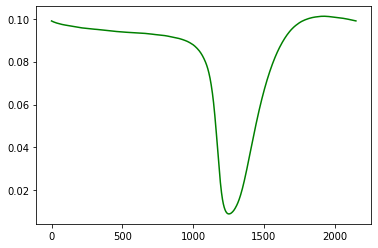

In [22]:
plt.plot(out[0, -2150:], 'g')

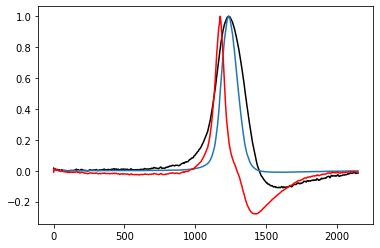

In [23]:
#plt.plot(u[:])
plt.plot(minmax(u[-2150:]), 'k')
plt.plot(minmax(uln[-2150:]))
plt.plot(minmax(out[1, -2150:]), 'r')

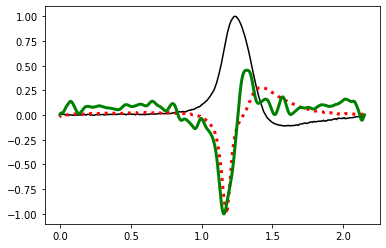

In [24]:
plt.plot(np.linspace(0, 2.15, 2150), u[-2150:], 'k')
plt.plot(np.linspace(0, 2.15, 2150), -minmax(out[1, -2150:]), 'r:', linewidth=3)
plt.plot(np.linspace(0, 2.15, 2150), l['y']['s_2_1ms_mm'], linewidth=3, color='green')
#plt.savefig('lnk_param_changed.pdf', bbox_inches='tight', transparent=True, dpi=300)

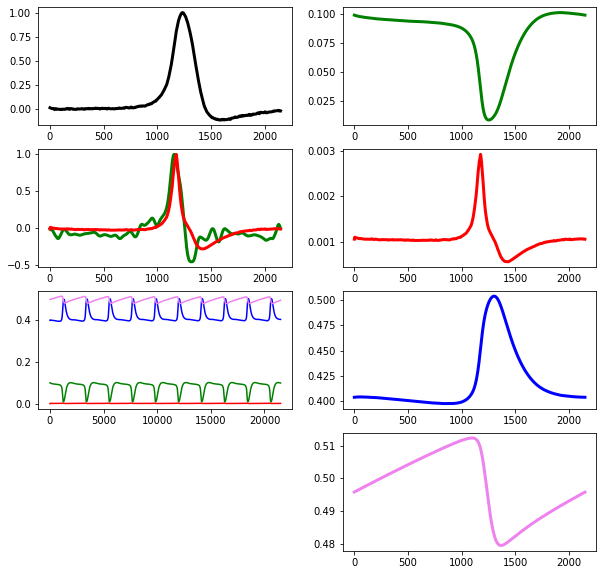

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 2, 1)
ax.plot(u[-2150:], 'k', linewidth=3)
ax = plt.subplot(4, 2, 3)
ax.plot(minmax(-l['y']['s_2_1ms_mm']), 'g', linewidth=3)
ax.plot(minmax(out[1, -2150:]), 'r', linewidth=3)

ax = plt.subplot(4, 2, 5)
ax.plot(out[0, :], 'g')
ax.plot(out[1, :], 'r')
ax.plot(out[2, :], 'b')
ax.plot(out[3, :], 'violet')

ax = plt.subplot(4, 2, 2)
ax.plot(out[0, -2150:], 'g', linewidth=3)
ax = plt.subplot(4, 2, 4)
ax.plot(out[1, -2150:], 'r', linewidth=3)
ax = plt.subplot(4, 2, 6)
ax.plot(out[2, -2150:], 'b', linewidth=3)
ax = plt.subplot(4, 2, 8)
ax.plot(out[3, -2150:], 'violet', linewidth=3)

#plt.savefig('lnk_param_fit_full.pdf', bbox_inches='tight', transparent=True, dpi=300)

## (v2) With New nonlinearity & Kinetics block parameters

In [19]:
uln = lnk.simulate_nonlinearity_2(u, [-1.0702, 5.1419])
out = lnk.simulate_4state_2(uln, np.array([24.246, 1781.68, 0.0392, 0.0577, 4.774, 121.402, -13.150]), np.array([0.01, 0.001, 99.489, 0.5]))

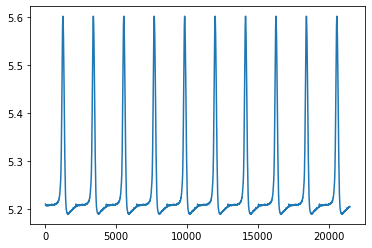

In [20]:
plt.plot(uln)

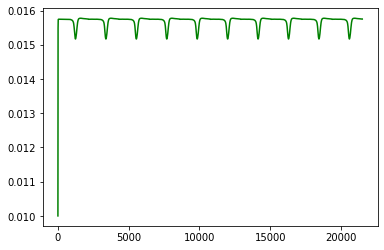

In [21]:
plt.plot(out[0, :], 'g')
#plt.plot(out[1, :], 'r')
#plt.plot(out[2, :], 'b')
#plt.plot(out[3, :], color='violet')

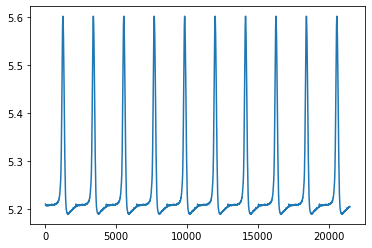

In [22]:
plt.plot(uln)

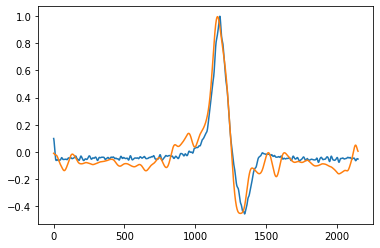

In [23]:
plt.plot(minmax(smooth_1d(out[1, -2150:], 5)))
#plt.plot(minmax(u[-2150:]), 'k')
plt.plot(smooth_1d(-l['y']['s_2_1ms_mm'], 3))

In [24]:
scipy.stats.pearsonr(minmax(out[1, -2140:]), -l['y']['s_2_1ms_mm'][-2140:])

(0.9499658988247741, 0.0)

## (v3) With New nonlinearity & Kinetics block parameters (different parameter set)

In [18]:
uln = lnk.simulate_nonlinearity_2(smooth_1d(u, 5), [-1.05, 5.4])
out = lnk.simulate_4state_2(uln, np.array([87, 1020, 0.43, 0.05, 4.3, 100, -9.5]), np.array([0.07, 0.02, 99.61, 0.3]))

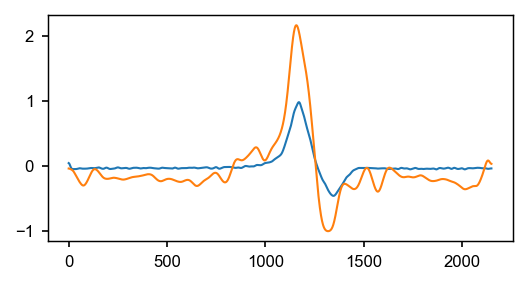

In [19]:
plt.plot(smooth_1d(minmax(out[1, -2150:]), 5))
plt.plot(smooth_1d(-l['y']['s_2_1ms_mm'], 5))

In [36]:
scipy.stats.pearsonr(minmax(smooth_1d(out[1, -2140:], 5)), minmax(smooth_1d(-l['y']['s_2_1ms_mm'][-2140:], 5)))

(0.9584371444660094, 0.0)

In [37]:
scipy.stats.pearsonr(minmax(smooth_1d(out[1, -2150+1067-200:-2150+1067+400], 5)), 
                     minmax(smooth_1d(-l['y']['s_2_1ms_mm'][-2150+1067-200:-2150+1067+400], 5)))         # -0.2s : 0.4s

(0.975297291899153, 0.0)

## correlation: 0.958

Text(0, 0.5, 'Normalized activity')

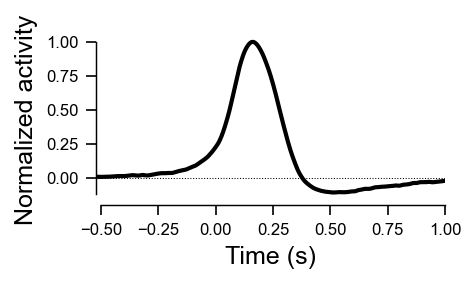

In [20]:
fig = plt.figure(figsize=(3, 1.5))
ax = plt.subplot(111)
ax.plot(np.arange(-1.075, 1.075, 0.001), minmax(smooth_1d(u[-2150:], 5)), color='black', linewidth=2)
ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.52, 1.0])
ax.set_ylim([-0.20, 1.05])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 1.0)
ax.spines['left'].set_bounds(-0.12, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized activity')
#ax.legend(fontsize=8, loc=3)

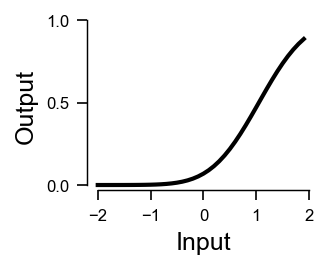

In [202]:
fig = plt.figure(figsize=(2, 1.5))
ax = plt.subplot(111)
ax.plot(np.arange(-2, 2, 0.1), (scipy.special.erf(np.arange(-2, 2, 0.1) - 1.05) + 1)/2, color='black', linewidth=2)
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-0.03, 1.0])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-2.0, 2.0)
ax.spines['left'].set_bounds(-0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.set_xlabel('Input')
ax.set_ylabel('Output')

#plt.savefig('fig_lnk_nonlinearity.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [22]:
lin_filter = np.stack([ex.rf['i']['st'][i] for i in idx_i])
lin_filter_space = np.stack([ft.decompose(ft.smooth(lin_filter[i], .5, .5))[0]
                             [ft.filterpeak(ft.smooth(lin_filter[i], 1, 1))[1][1]-6:ft.filterpeak(ft.smooth(lin_filter[i], 1, 1))[1][1]+7, 
                              ft.filterpeak(ft.smooth(lin_filter[i], 1, 1))[1][0]-6:ft.filterpeak(ft.smooth(lin_filter[i], 1, 1))[1][0]+7] for i in range(idx_i.shape[0])])
lin_filter_time = np.stack([ft.decompose(ft.smooth(lin_filter[i], .5, .5))[1] for i in range(idx_i.shape[0])])

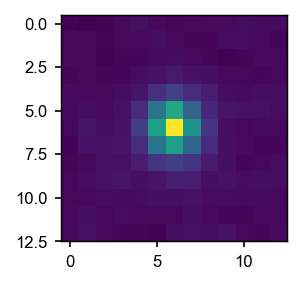

In [23]:
plt.imshow(np.mean(lin_filter_space, 0))  # 11 out of 32 boxes (32 boxes = 256 pixel)

In [24]:
#plt.plot(np.mean(lin_filter_space, 0)[5, :])

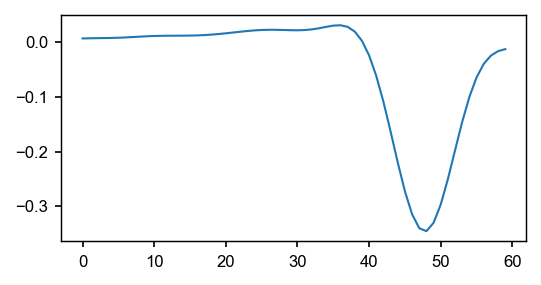

In [25]:
plt.plot(np.mean(lin_filter_time, 0))

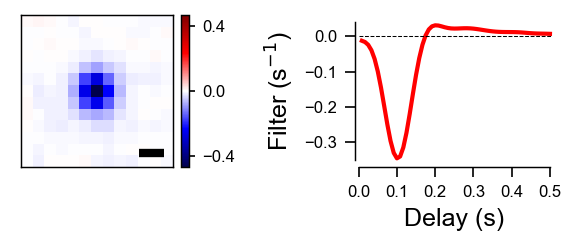

In [203]:
fig = plt.figure(figsize=(4.2, 1.8))
ax = plt.subplot(121)
im = ax.imshow(-np.mean(lin_filter_space, 0), cmap='seismic', vmin=-np.max(abs(np.mean(lin_filter_space, 0))), 
               vmax=np.max(abs(np.mean(lin_filter_space, 0))), interpolation='nearest', extent=[-104*(100/17)/2,104*(100/17)/2,-104*(100/17)/2,104*(100/17)/2])
cb = fig.colorbar(im, ticks=[-0.4, 0, 0.4], fraction=0.046, pad=0.04)
ax.plot([170, 270], [-250, -250], linewidth=4, color='black', solid_capstyle='butt')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xlabel('Space (${\mu}$m)')

ax = plt.subplot(122)
ax.plot(np.linspace(0, 0.5, 61)[1:], np.mean(lin_filter_time, 0)[::-1], color='red', linewidth=2)
ax.axhline(y=0, xmin=0.02, xmax=0.99, color='k', linestyle='--', linewidth=0.5)
ax.set_xlim([-0.01, 0.51])
ax.set_ylim([-0.37, 0.06])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.0, 0.5)
ax.spines['left'].set_bounds(-0.35, 0.04)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax.set_xlabel('Delay (s)')
ax.set_ylabel('Filter (s$^{-1}$)')

fig.tight_layout()

#plt.savefig('fig_lnk_linearfilter.pdf', bbox_inches='tight', transparent=True, dpi=300)

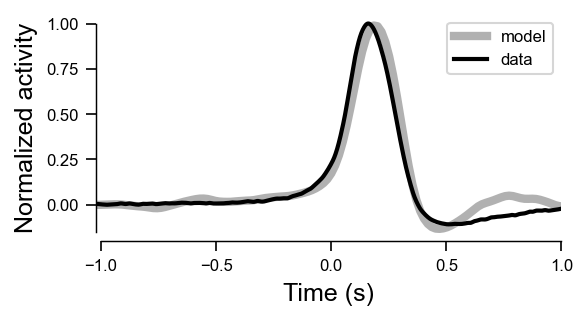

In [234]:
#plt.plot(np.arange(0, 129*(1/60), 1/60)-1.0667, np.mean(ex.i_a['mb_lin_line_baseline0_cen_i'][idx_i], axis=(0, 1, 2, 3))/1.7, color='black', linewidth=3, alpha=0.8)

fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(111)
ax.plot(np.linspace(0, 2.15, 129)-1.075, np.mean(ex.i_a['mb_lin_line_baseline0_cen_i'][idx_i], axis=(0, 1, 2, 3))/1.7, color='darkgray', linewidth=4, alpha=0.9, label='model')
ax.plot(np.arange(-1.075, 1.075, 0.001), minmax(smooth_1d(u[-2150:], 5)), color='black', linewidth=2, label='data')
#ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-1.02, 1])
ax.set_ylim([-0.2, 1.05])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-1, 1)
ax.spines['left'].set_bounds(-0.15, 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized activity')
ax.legend(fontsize=8, loc=1)

#plt.savefig('fig_lnk_data+linearmodelfit.pdf', bbox_inches='tight', transparent=True, dpi=300)

Text(0, 0.5, 'Nonlinearity output')

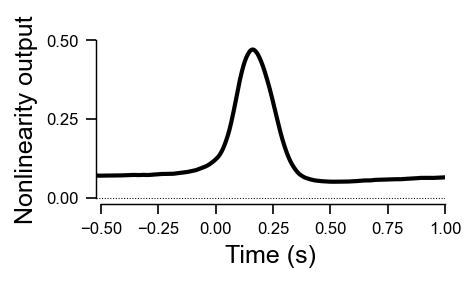

In [221]:
#plt.plot(minmax(u[-2150:]), 'r')
fig = plt.figure(figsize=(3, 1.5))
ax = plt.subplot(111)
ax.plot(np.arange(-1.075, 1.075, 0.001), uln[-2150:] - 5.4, color='black', linewidth=2)
ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.52, 1.0])
ax.set_ylim([-0.02, 0.52])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 1.0)
ax.spines['left'].set_bounds(0, 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Nonlinearity output')
#ax.legend(fontsize=8, loc=3)

## Model fit with two different parameters

In [75]:
N_a = 19
N_b = 19
out_mat = np.zeros((N_a, N_b, 2140))
cc_mat = np.zeros((N_a, N_b))
peak_mat = np.zeros((N_a, N_b))
#mse_mat = np.zeros((N_a, N_b))
out_max_mat = np.zeros((N_a, N_b))
N_a_range = np.linspace(-1000, 800, N_a)
N_b_range = np.linspace(-0.4, 10, N_b)
for ia, a in enumerate(N_a_range):
    for ib, b in enumerate(N_b_range):
        
        uln = lnk.simulate_nonlinearity_2(smooth_1d(u[10*-2150:], 5), [-1.05, 5.4])     # add a or b to specific parameters to fit              # -1, 5 // -0.9, 4.8
        out = lnk.simulate_4state_2(uln, np.array([87, 1020+a, 0.43+b, 0.05, 4.3, 100, -9.5]), np.array([0.07, 0.02, 99.61, 0.3]))[1, -2140:]   # 20, 300, 2, 0.1, 0.1, 0, 0
        
        out_max_mat[ia, ib] = np.argmax(out)
        out_mat[ia, ib, :] = out
        if np.isnan(out[0]):
            cc_mat[ia, ib] = -1
            peak_mat[ia, ib] = 0
            #mse_mat[ia, ib] = 100
        else:
            cc_mat[ia, ib] = np.round(100*scipy.stats.pearsonr(out, -l['y']['s_2_1ms_mm'][-2140:])[0])/100
            peak_mat[ia, ib] = abs(np.argmax(minmax(out)) - np.argmax(minmax(-l['y']['s_2_1ms_mm'][-2140:])))
            #mse_mat[ia, ib] = np.sum((minmax(out) - (-l['y']['s_2_1ms_mm']))**2)/2140

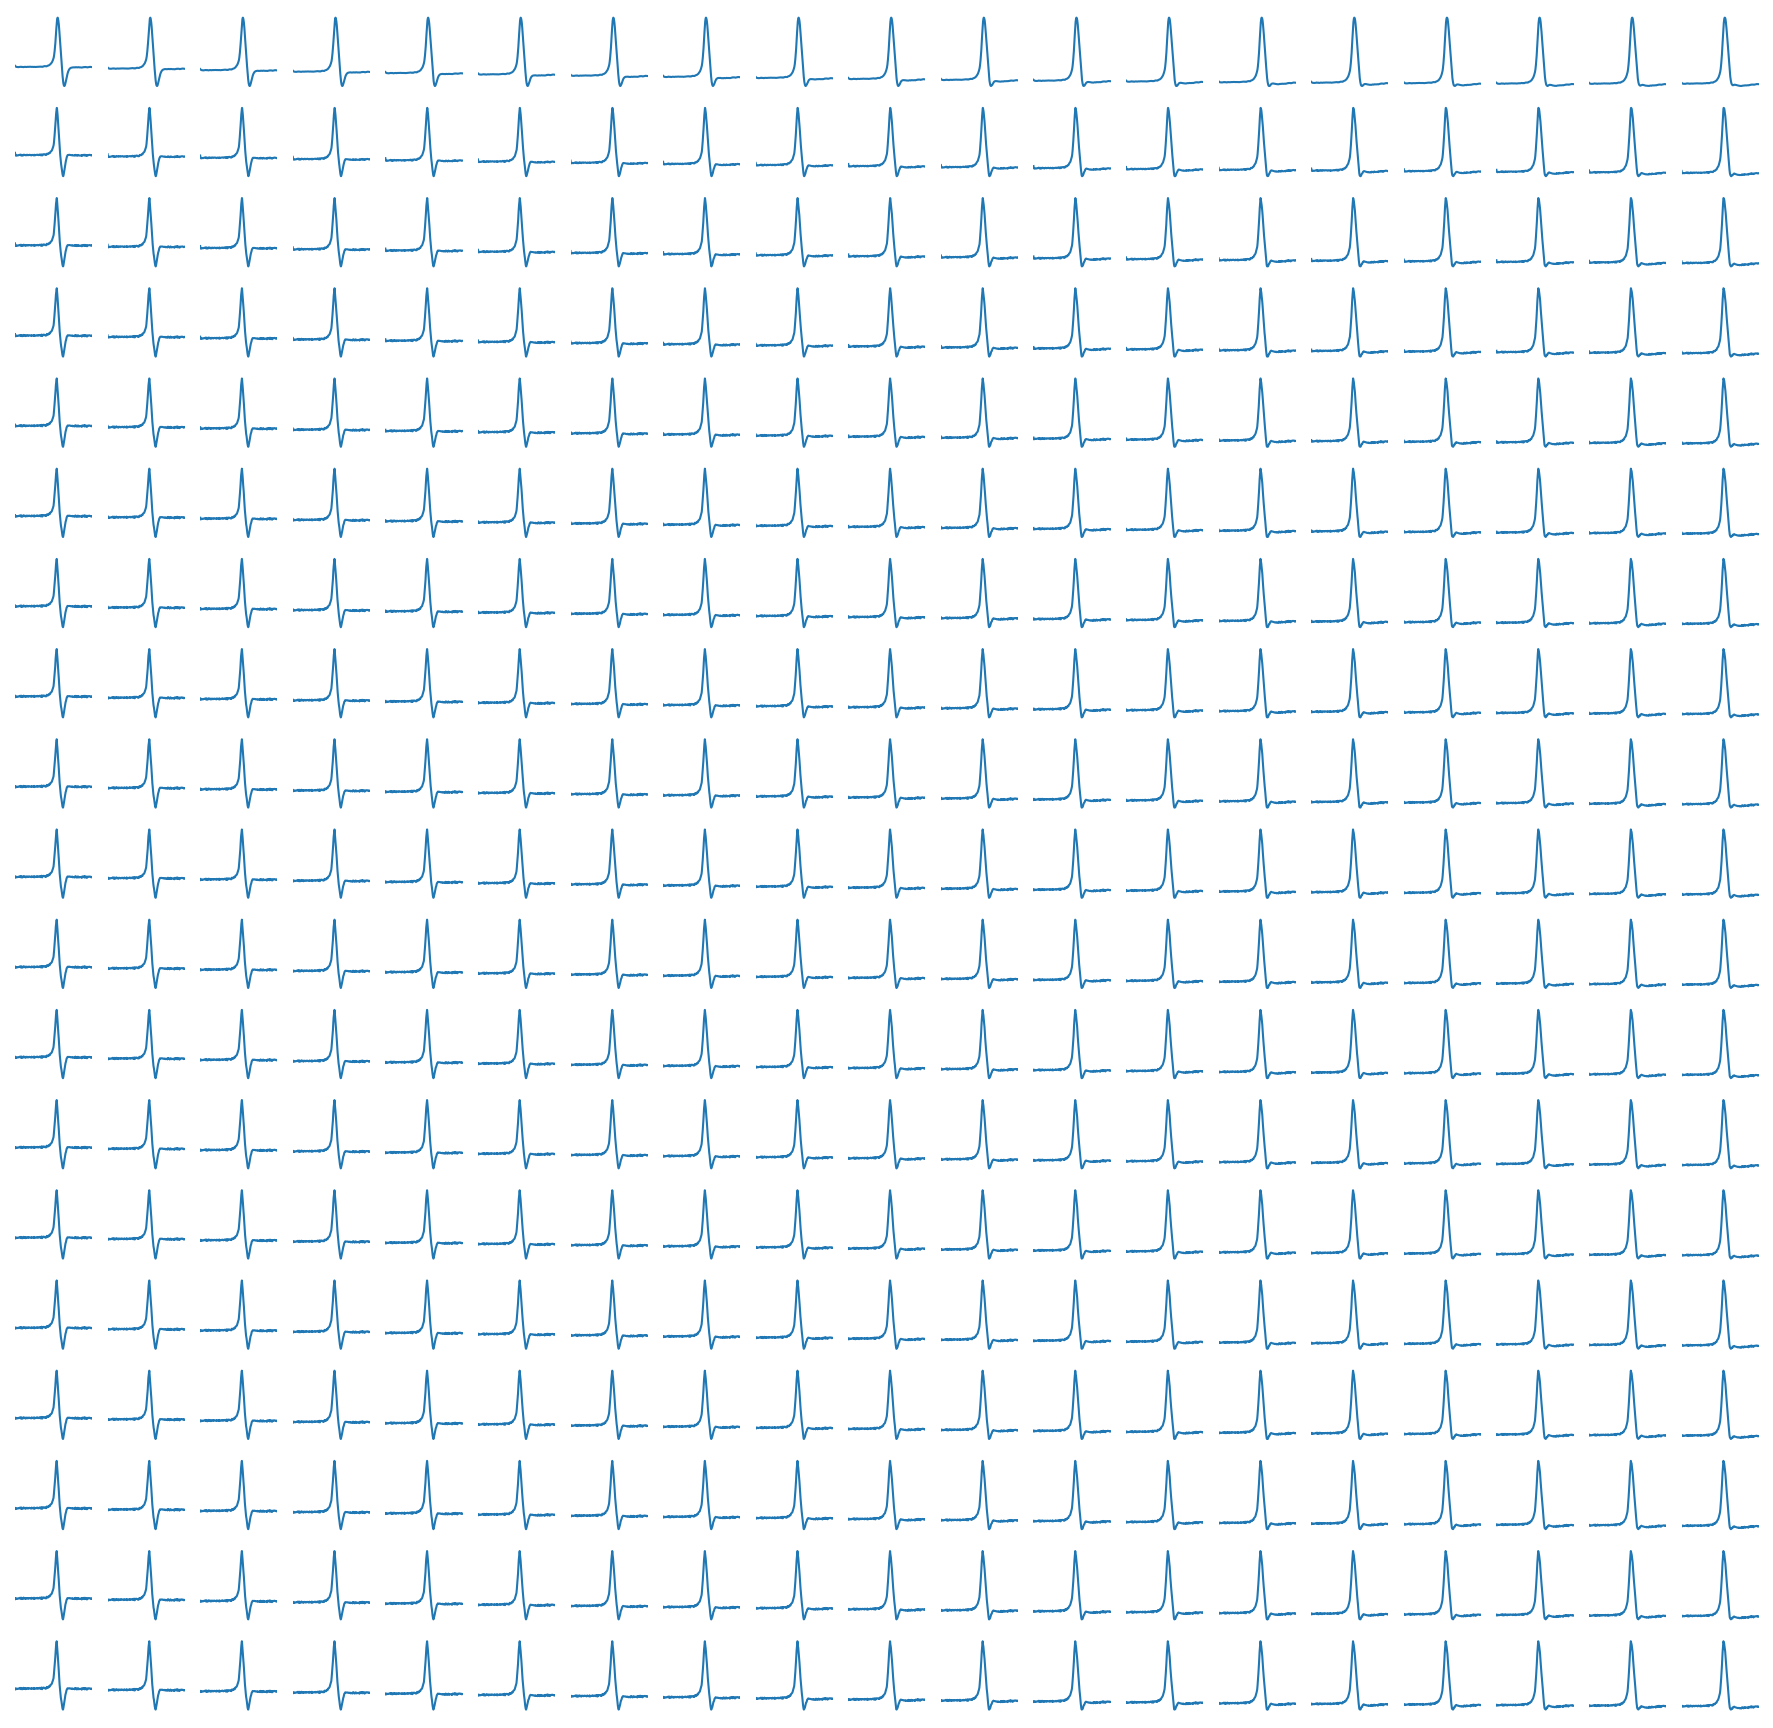

In [76]:
fig = plt.figure(figsize=(15, 15))
i = 1
for a in range(N_a):
    for b in range(N_b):
        ax = plt.subplot(N_a, N_b, i)
        ax.plot(out_mat[a, b, :])
        ax.set_xlim(0, 2150)
        #ax.set_ylim(0, 3)
        ax.axis('off')
        #ax.text(0, 0, a)
        #ax.text(500, 0, b)
        i += 1

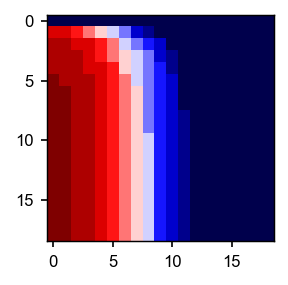

In [77]:
plt.imshow(np.round(cc_mat*100)/100, cmap='seismic', vmin=cc_mat.min()+0.3, vmax=cc_mat.max())
#plt.imshow(cc_mat, cmap='seismic', vmin=0, vmax=1)

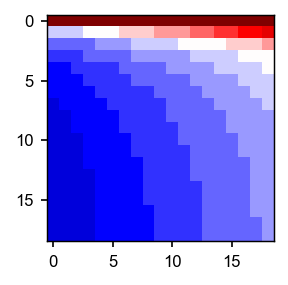

In [78]:
plt.imshow(peak_mat, cmap='seismic', vmin=10, vmax=30)

In [79]:
np.nanmax(cc_mat), np.nanmin(cc_mat), (np.nanmax(cc_mat)-np.nanmin(cc_mat))/np.nanmax(cc_mat)*100

(0.96, 0.55, 42.70833333333333)

In [80]:
cc_mat_a, cc_mat_b = np.unravel_index(cc_mat.argmax(), cc_mat.shape)
cc_mat_a, cc_mat_b

(5, 0)

In [81]:
N_a_range[10], N_b_range[10]

(0.0, 5.377777777777778)

In [82]:
N_a_range[cc_mat_a], N_b_range[cc_mat_b]

(-500.0, -0.4)

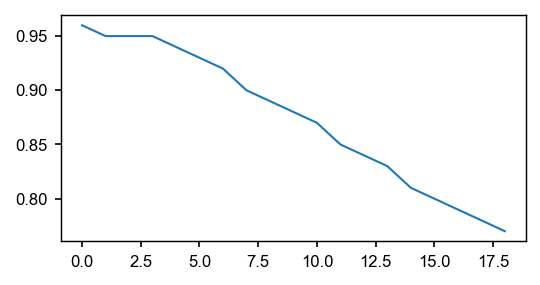

In [83]:
plt.plot(np.round(cc_mat[cc_mat_a, :]*100)/100)

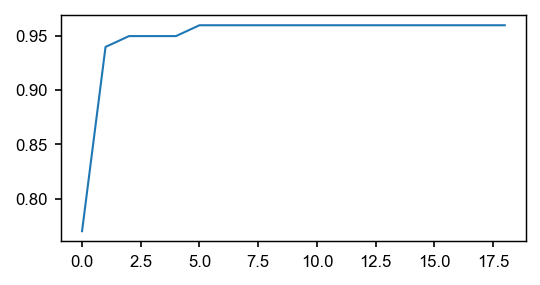

In [84]:
plt.plot(np.round(cc_mat[:, cc_mat_b]*1000)/1000)

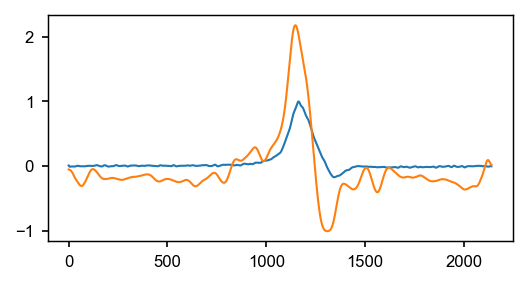

In [85]:
plt.plot(minmax(out_mat[9, 9, :]))
plt.plot(-l['y']['s_2_1ms_mm'][-2140:])

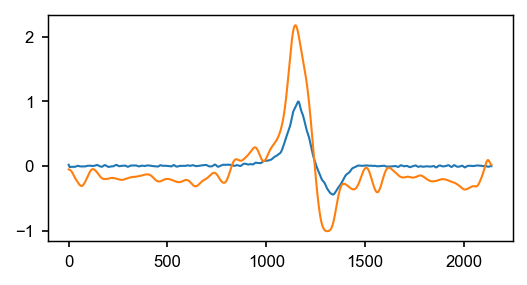

In [86]:
plt.plot(minmax(out_mat[cc_mat_a, cc_mat_b, :]))
plt.plot(-l['y']['s_2_1ms_mm'][-2140:])

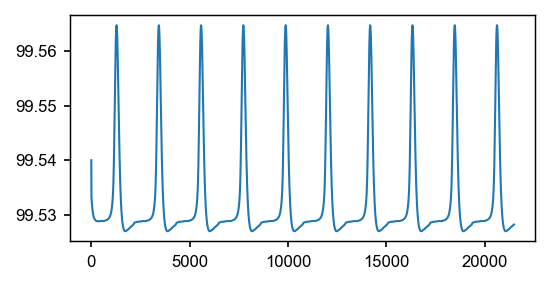

In [87]:
uln = lnk.simulate_nonlinearity_2(smooth_1d(u[10*-2150:], 5), [-1.05, 5.4])     # add a or b to specific parameters to fit              # -1, 5 // -0.9, 4.8
out = lnk.simulate_4state_2(uln, np.array([87, 1020, 0.43, 0.05, 4.3, 100, -9.5]), np.array([0.07, 0.04, 99.54, 0.35]))
plt.plot(out[2, :])

## Compute Hessian matrix (with v2 parameters)

In [27]:
#            nl-offsets     k_a     k_fi     k_fr    k_si   k_sr
pr_hat = [-1.0702, 5.1419, 24.246, 1781.68, 0.0392, 0.0577, 4.774]
#       k_a-offset k_sr-offset
pr_fix = [121.402, -13.150]
state_0 = [0.01, 0.001, 99.489, 0.5]
pr_hat

[-1.0702, 5.1419, 24.246, 1781.68, 0.0392, 0.0577, 4.774]

In [28]:
N_step = 5  # odd
step_size = 1e-2 * 5
pr_mat = np.zeros((len(pr_hat), N_step))
pr_fix_mat = np.zeros((len(pr_fix), N_step))
for i1 in range(len(pr_hat)):
    for i2 in range(N_step):
        if i1 == 0:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * abs(u.max() - u.min())
        elif i1 == 1:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * abs(uln.max() - uln.min())
        elif i1 == 2:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * pr_hat[i1]
            pr_fix_mat[0, i2] = abs(pr_fix[0]) + (i2 - int(np.floor(N_step/2))) * (step_size) * abs(pr_fix[0])
        elif i1 == 3:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * pr_hat[i1]
        elif i1 == 4:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * pr_hat[i1]
        elif i1 == 5:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * pr_hat[i1]
        elif i1 == 6:
            pr_mat[i1, i2] = pr_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * pr_hat[i1]
            pr_fix_mat[1, i2] = -(abs(pr_fix[1]) + (i2 - int(np.floor(N_step/2))) * (step_size) * abs(pr_fix[1]))

In [30]:
pr_mat, pr_fix_mat

(array([[-1.18124183e+00, -1.12572091e+00, -1.07020000e+00,
         -1.01467909e+00, -9.59158170e-01],
        [ 5.10060358e+00,  5.12125179e+00,  5.14190000e+00,
          5.16254821e+00,  5.18319642e+00],
        [ 2.18214000e+01,  2.30337000e+01,  2.42460000e+01,
          2.54583000e+01,  2.66706000e+01],
        [ 1.60351200e+03,  1.69259600e+03,  1.78168000e+03,
          1.87076400e+03,  1.95984800e+03],
        [ 3.52800000e-02,  3.72400000e-02,  3.92000000e-02,
          4.11600000e-02,  4.31200000e-02],
        [ 5.19300000e-02,  5.48150000e-02,  5.77000000e-02,
          6.05850000e-02,  6.34700000e-02],
        [ 4.29660000e+00,  4.53530000e+00,  4.77400000e+00,
          5.01270000e+00,  5.25140000e+00]]),
 array([[109.2618, 115.3319, 121.402 , 127.4721, 133.5422],
        [-11.835 , -12.4925, -13.15  , -13.8075, -14.465 ]]))

In [31]:
cc_mat_step = np.zeros((N_step, N_step, N_step, N_step, N_step, N_step, N_step))
peak_mat_step = np.zeros((N_step, N_step, N_step, N_step, N_step, N_step, N_step))
width_mat_step = np.zeros((N_step, N_step, N_step, N_step, N_step, N_step, N_step))
for i1, p1 in enumerate(pr_mat[0, :]):
    for i2, p2 in enumerate(pr_mat[1, :]):
        for i3, p3 in enumerate(pr_mat[2, :]):
            for i4, p4 in enumerate(pr_mat[3, :]):
                for i5, p5 in enumerate(pr_mat[4, :]):
                    for i6, p6 in enumerate(pr_mat[5, :]):
                        for i7, p7 in enumerate(pr_mat[6, :]):
                            uln = lnk.simulate_nonlinearity_2(u[-3*2150:], [p1, p2])
                            out = lnk.simulate_4state_2(uln, np.array([p3, p4, p5, p6, p7, pr_fix_mat[0, i3], pr_fix_mat[1, i7]]), np.array([0.01, 0.001, 99.489, 0.5]))[1, -2150:] 
                            cc_mat_step[i1, i2, i3, i4, i5, i6, i7] = scipy.stats.pearsonr(out[-2140:], -l['y']['s_2_1ms_mm'][-2140:])[0]
                            peak_mat_step[i1, i2, i3, i4, i5, i6, i7] = np.sqrt((argmax(minmax(smooth_1d(out, 5))) - argmax(minmax(-l['y']['s_2_1ms_mm'])))**2)
                            width_mat_step[i1, i2, i3, i4, i5, i6, i7] = np.sqrt((arghalf_width(minmax(smooth_1d(out, 5))) - arghalf_width(minmax(-l['y']['s_2_1ms_mm'])))**2)

## Save matrix

In [32]:
with open('/home/dlee/lnk-moving-bar/python/cc_5p.p', 'wb') as file_cc:
    pickle.dump(cc_mat_step, file_cc)
with open('/home/dlee/lnk-moving-bar/python/peak_5p.p', 'wb') as file_peak:
    pickle.dump(peak_mat_step, file_peak)
with open('/home/dlee/lnk-moving-bar/python/width_5p.p', 'wb') as file_width:
    pickle.dump(width_mat_step, file_width)

## Load saved matrix

In [26]:
with open('/home/dlee/lnk-moving-bar/python/cc_5p.p', 'rb') as file_cc:
    cc_mat_step = pickle.load(file_cc)
with open('/home/dlee/lnk-moving-bar/python/peak_5p.p', 'rb') as file_peak:
    peak_mat_step = pickle.load(file_peak)
with open('/home/dlee/lnk-moving-bar/python/width_5p.p', 'rb') as file_width:
    width_mat_step = pickle.load(file_width)

## Compute Hessian (kinetic parameters only; with v3 parameters)

In [19]:
pr_k_hat = [87, 1020, 0.43, 0.05, 4.3] 
pr_k_fix = [-1.05, 5.4, 100, -9.5]     
state_0 = [0.07, 0.04, 99.54, 0.35] 

N_step = 5  # odd
step_size = 1e-2 * 35 # percent

pr_k_mat = np.zeros((len(pr_k_hat), N_step))
pr_k_fix_mat = np.zeros((len(pr_k_fix), N_step))
for i1 in range(len(pr_k_hat)):
    for i2 in range(N_step):
        pr_k_mat[i1, i2] = pr_k_hat[i1] + (i2 - int(np.floor(N_step/2))) * (step_size) * pr_k_hat[i1]
        
for i1 in range(len(pr_k_fix)):
    for i2 in range(N_step):
        if i1 == 0:
            pr_k_fix_mat[i1, i2] = pr_k_fix[i1]
        elif i1 == 1:
            pr_k_fix_mat[i1, i2] = pr_k_fix[i1]
        elif i1 == 2:
            pr_k_fix_mat[i1, i2] = abs(pr_k_fix[i1]) + (i2 - int(np.floor(N_step/2))) * (step_size) * abs(pr_k_fix[i1])
        elif i1 == 3:
            pr_k_fix_mat[i1, i2] = -(abs(pr_k_fix[i1]) + (i2 - int(np.floor(N_step/2))) * (step_size) * abs(pr_k_fix[i1]))

In [20]:
pr_k_mat

array([[2.6100e+01, 5.6550e+01, 8.7000e+01, 1.1745e+02, 1.4790e+02],
       [3.0600e+02, 6.6300e+02, 1.0200e+03, 1.3770e+03, 1.7340e+03],
       [1.2900e-01, 2.7950e-01, 4.3000e-01, 5.8050e-01, 7.3100e-01],
       [1.5000e-02, 3.2500e-02, 5.0000e-02, 6.7500e-02, 8.5000e-02],
       [1.2900e+00, 2.7950e+00, 4.3000e+00, 5.8050e+00, 7.3100e+00]])

In [21]:
pr_k_fix_mat

array([[ -1.05 ,  -1.05 ,  -1.05 ,  -1.05 ,  -1.05 ],
       [  5.4  ,   5.4  ,   5.4  ,   5.4  ,   5.4  ],
       [ 30.   ,  65.   , 100.   , 135.   , 170.   ],
       [ -2.85 ,  -6.175,  -9.5  , -12.825, -16.15 ]])

In [211]:
cc_k_mat_step = np.zeros((N_step, N_step, N_step, N_step, N_step))
peak_k_mat_step = np.zeros((N_step, N_step, N_step, N_step, N_step))
width_k_mat_step = np.zeros((N_step, N_step, N_step, N_step, N_step))
for i1, p1 in enumerate(pr_k_mat[0, :]):
    for i2, p2 in enumerate(pr_k_mat[1, :]):
        for i3, p3 in enumerate(pr_k_mat[2, :]):
            for i4, p4 in enumerate(pr_k_mat[3, :]):
                for i5, p5 in enumerate(pr_k_mat[4, :]):
                    uln = lnk.simulate_nonlinearity_2(smooth_1d(u[-10*2150:], 5), [pr_k_fix_mat[0, 0], pr_k_fix_mat[1, 0]])
                    out = lnk.simulate_4state_2(uln, np.array([p1, p2, p3, p4, p5, pr_k_fix_mat[2, i1], pr_k_fix_mat[3, i5]]), np.array(state_0))[1, -2150:] 
                    y_hat = minmax(smooth_1d(out, 5))
                    y_true = minmax(smooth_1d(-l['y']['s_2_1ms_mm'], 5))
                    cc_k_mat_step[i1, i2, i3, i4, i5] = scipy.stats.pearsonr(y_hat[-2140:], y_true[-2140:])[0]
                    peak_k_mat_step[i1, i2, i3, i4, i5] = abs(argmax(y_hat) - argmax(y_true))
                    width_k_mat_step[i1, i2, i3, i4, i5] = abs(arghalf_width(y_hat) - arghalf_width(y_true))

## Save hessian matrix

In [212]:
with open('/home/dlee/lnk-moving-bar/python/cc_k_35p.p', 'wb') as file_cc:
    pickle.dump(cc_k_mat_step, file_cc)
with open('/home/dlee/lnk-moving-bar/python/peak_k_35p.p', 'wb') as file_peak:
    pickle.dump(peak_k_mat_step, file_peak)
with open('/home/dlee/lnk-moving-bar/python/width_k_35p.p', 'wb') as file_width:
    pickle.dump(width_k_mat_step, file_width)

## Load hessian matrix

In [89]:
with open(HOME + '/dlee/lnk-moving-bar/python/cc_k_35p.p', 'rb') as file_cc:
    cc_k_mat_step = pickle.load(file_cc)
with open(HOME + '/dlee/lnk-moving-bar/python/peak_k_35p.p', 'rb') as file_peak:
    peak_k_mat_step = pickle.load(file_peak)
with open(HOME + '/dlee/lnk-moving-bar/python/width_k_35p.p', 'rb') as file_width:
    width_k_mat_step = pickle.load(file_width)

In [90]:
cc_k_mat_step.shape

(5, 5, 5, 5, 5)

In [91]:
np.unravel_index(cc_k_mat_step.argmax(), cc_k_mat_step.shape)

(4, 4, 0, 1, 2)

In [92]:
cc_k_mat_step[2, 2, 2, 2, 2], cc_k_mat_step[np.unravel_index(cc_k_mat_step.argmax(), cc_k_mat_step.shape)]

(0.9584816561654323, 0.9613313924134845)

In [93]:
np.min(cc_k_mat_step), np.max(cc_k_mat_step)

(0.24726537583798158, 0.9613313924134845)

In [94]:
np.min(peak_k_mat_step), np.max(peak_k_mat_step)

(11.0, 21.0)

In [95]:
np.min(width_k_mat_step), np.max(width_k_mat_step)

(0.0, 354.0)

In [96]:
cc_k_mat_step_0 = 0.958
peak_k_mat_step_0 = 100
width_k_mat_step_0 = 110

cc_k_hess = hessian(np.round(200*((cc_k_mat_step_0 - cc_k_mat_step)/cc_k_mat_step_0))/200)
peak_k_hess = hessian(peak_k_mat_step/peak_k_mat_step_0)
width_k_hess = hessian(width_k_mat_step/width_k_mat_step_0)

In [97]:
cc_k_hess_p = cc_k_hess[:, :, 2, 2, 2, 2, 2]
peak_k_hess_p = peak_k_hess[:, :, 2, 2, 2, 2, 2]
width_k_hess_p = width_k_hess[:, :, 2, 2, 2, 2, 2]

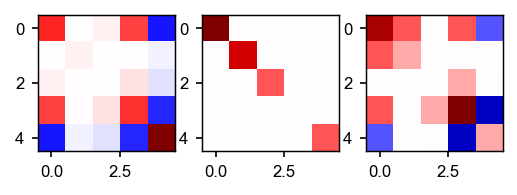

In [98]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(131)
ax.imshow(cc_k_hess_p, cmap='seismic', vmin=-np.max(abs(cc_k_hess_p)), vmax=np.max(abs(cc_k_hess_p)))
ax = plt.subplot(132)
ax.imshow(peak_k_hess_p, cmap='seismic', vmin=-np.max(abs(peak_k_hess_p)), vmax=np.max(abs(peak_k_hess_p)))
ax = plt.subplot(133)
ax.imshow(width_k_hess_p, cmap='seismic', vmin=-np.max(abs(width_k_hess_p)), vmax=np.max(abs(width_k_hess_p)))

In [99]:
cc_val, cc_vec = np.linalg.eig(cc_k_hess_p)
cc_idx = np.argsort(cc_val)[::-1]
cc_eigenval = cc_val[cc_idx]
cc_eigenvec = cc_vec[:, cc_idx]

peak_val, peak_vec = np.linalg.eig(peak_k_hess_p)
peak_idx = np.argsort(peak_val)[::-1]
peak_eigenval = peak_val[peak_idx]
peak_eigenvec = peak_vec[:, peak_idx]

width_val, width_vec = np.linalg.eig(width_k_hess_p)
width_idx = np.argsort(width_val)[::-1]
width_eigenval = width_val[width_idx]
width_eigenvec = width_vec[:, width_idx]

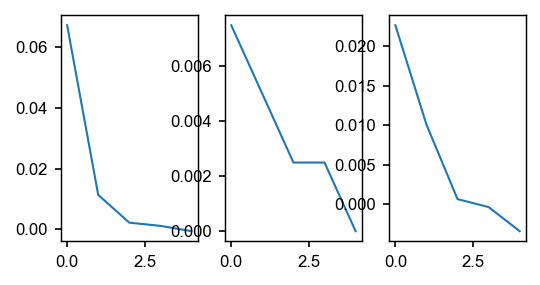

In [100]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(131)
ax.plot(cc_eigenval)
ax = plt.subplot(132)
ax.plot(peak_eigenval)
ax = plt.subplot(133)
ax.plot(width_eigenval)

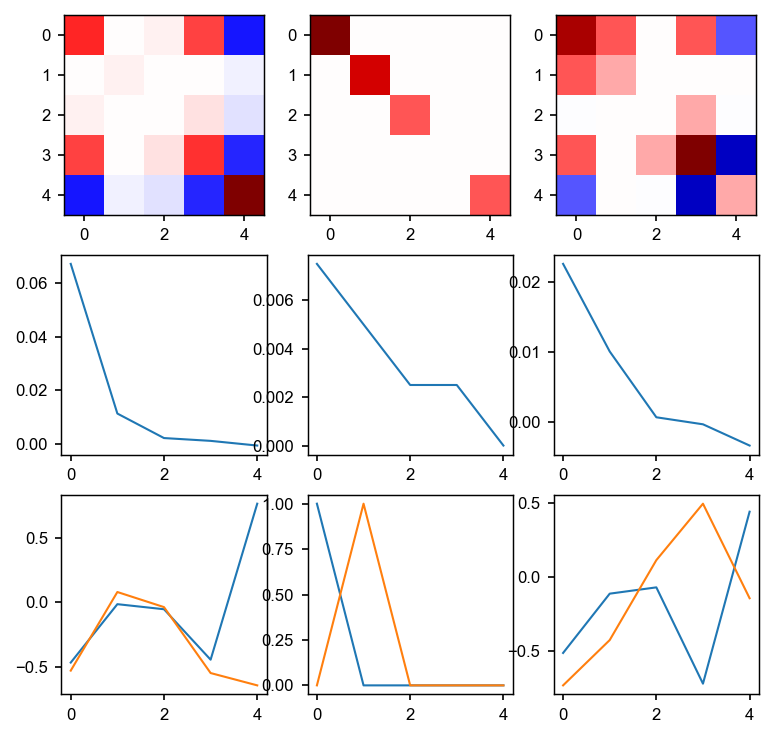

In [101]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(331)
ax.imshow(cc_k_hess_p, cmap='seismic', vmin=-np.max(abs(cc_k_hess_p)), vmax=np.max(abs(cc_k_hess_p)))
#plt.colorbar()
ax = plt.subplot(332)
ax.imshow(peak_k_hess_p, cmap='seismic', vmin=-np.max(abs(peak_k_hess_p)), vmax=np.max(abs(peak_k_hess_p)))
ax = plt.subplot(333)
ax.imshow(width_k_hess_p, cmap='seismic', vmin=-np.max(abs(width_k_hess_p)), vmax=np.max(abs(width_k_hess_p)))

ax = plt.subplot(334)
ax.plot(cc_eigenval)
ax = plt.subplot(335)
ax.plot(peak_eigenval)
ax = plt.subplot(336)
ax.plot(width_eigenval)

ax = plt.subplot(337)
plt.plot(cc_eigenvec[:, 0])
plt.plot(cc_eigenvec[:, 1])
ax = plt.subplot(338)
plt.plot(peak_eigenvec[:, 0])
plt.plot(peak_eigenvec[:, 1])
ax = plt.subplot(339)
plt.plot(width_eigenvec[:, 0])
plt.plot(width_eigenvec[:, 1])
#plt.savefig('lnk_param_fit_hessian+eigenval+eigenvec.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [102]:
pr_hat = [87, 1020, 0.43, 0.05, 4.3] 
pr_fix = [-1.05, 5.4, 100, -9.5]
state_0 = [0.07, 0.04, 99.54, 0.35]

In [103]:
N_a = 21
N_b = 21
cc_pr_eigen_mat = np.zeros((N_a, N_b, 5))
cc_fix_eigen_mat = np.zeros((N_a, N_b, 2))
cc_out_eigen_mat = np.zeros((N_a, N_b, 2150))
cc_eigen_mat = np.zeros((N_a, N_b))
peak_pr_eigen_mat = np.zeros((N_a, N_b, 5))
peak_fix_eigen_mat = np.zeros((N_a, N_b, 2))
peak_out_eigen_mat = np.zeros((N_a, N_b, 2150))
peak_eigen_mat = np.zeros((N_a, N_b))
width_pr_eigen_mat = np.zeros((N_a, N_b, 5))
width_fix_eigen_mat = np.zeros((N_a, N_b, 2))
width_out_eigen_mat = np.zeros((N_a, N_b, 2150))
width_eigen_mat = np.zeros((N_a, N_b))

for a in range(N_a):  
    for b in range(N_b):                                                     # 7 7 5
        cc_pr_eigen_mat[a, b, :] = pr_hat + (a - int(np.floor(N_a/2))) * (0.09) * cc_eigenvec[:, 0] * np.abs(pr_hat) + (b - int(np.floor(N_b/2))) * (0.09) * cc_eigenvec[:, 1] * np.abs(pr_hat)
        peak_pr_eigen_mat[a, b, :] = pr_hat + (a - int(np.floor(N_a/2))) * (0.09) * peak_eigenvec[:, 0] * np.abs(pr_hat) + (b - int(np.floor(N_b/2))) * (0.09) * peak_eigenvec[:, 1] * np.abs(pr_hat)
        width_pr_eigen_mat[a, b, :] = pr_hat + (a - int(np.floor(N_a/2))) * (0.09) * width_eigenvec[:, 0] * np.abs(pr_hat) + (b - int(np.floor(N_b/2))) * (0.09) * width_eigenvec[:, 1] * np.abs(pr_hat)
        
        cc_fix_eigen_mat[a, b, 0] = pr_fix[2] * (cc_pr_eigen_mat[a, b, 0]/pr_hat[0])
        cc_fix_eigen_mat[a, b, 1] = pr_fix[3] * (cc_pr_eigen_mat[a, b, -1]/pr_hat[-1])
        peak_fix_eigen_mat[a, b, 0] = pr_fix[2] * (peak_pr_eigen_mat[a, b, 0]/pr_hat[0])
        peak_fix_eigen_mat[a, b, 1] = pr_fix[3] * (peak_pr_eigen_mat[a, b, -1]/pr_hat[-1])
        width_fix_eigen_mat[a, b, 0] = pr_fix[2] * (width_pr_eigen_mat[a, b, 0]/pr_hat[0])
        width_fix_eigen_mat[a, b, 1] = pr_fix[3] * (width_pr_eigen_mat[a, b, -1]/pr_hat[-1])


for a in range(N_a):
    for b in range(N_b):
        uln = lnk.simulate_nonlinearity_2(smooth_1d(u[-10*2150:], 5), pr_fix[:2])
        out = lnk.simulate_4state_2(uln, np.append(np.append(list(cc_pr_eigen_mat[a, b, :]), cc_fix_eigen_mat[a, b, 0]), cc_fix_eigen_mat[a, b, 1]), np.array(state_0))[1, -2150:] 
        cc_out_eigen_mat[a, b, :] = out
        if np.isnan(out[0]) | np.isnan(out[-1]):
            cc_eigen_mat[a, b] = -1
        else:
            cc_eigen_mat[a, b] = scipy.stats.pearsonr(smooth_1d(out[-2140:], 5), -l['y']['s_2_1ms_mm'][-2140:])[0]
        
        uln = lnk.simulate_nonlinearity_2(smooth_1d(u[-10*2150:], 5), pr_fix[:2])
        out = lnk.simulate_4state_2(uln, np.append(np.append(list(peak_pr_eigen_mat[a, b, :]), peak_fix_eigen_mat[a, b, 0]), peak_fix_eigen_mat[a, b, 1]), np.array(state_0))[1, -2150:] 
        peak_out_eigen_mat[a, b, :] = out
        if np.isnan(out[0]) | np.isnan(out[-1]):
            peak_eigen_mat[a, b] = 100
        else:
            peak_eigen_mat[a, b] = abs(argmax(minmax(smooth_1d(out, 5))) - argmax(minmax(-l['y']['s_2_1ms_mm'])))
        
        uln = lnk.simulate_nonlinearity_2(smooth_1d(u[-10*2150:], 5), pr_fix[:2])
        out = lnk.simulate_4state_2(uln, np.append(np.append(list(width_pr_eigen_mat[a, b, :]), width_fix_eigen_mat[a, b, 0]), width_fix_eigen_mat[a, b, 1]), np.array(state_0))[1, -2150:] 
        width_out_eigen_mat[a, b, :] = out
        if np.isnan(out[0]) | np.isnan(out[-1]):
            width_eigen_mat[a, b] = 110
        else:
            width_eigen_mat[a, b] = abs(arghalf_width(minmax(smooth_1d(out, 5))) - arghalf_width(minmax(-l['y']['s_2_1ms_mm'])))

/Users/dlee/lnk-moving-bar/python/lnk.py:81: RuntimeWarning: overflow encountered in matmul
  x_curr = x_curr + 0.001 * np.matmul(x_curr.reshape(1, 4), Q).reshape(4,)
/Users/dlee/lnk-moving-bar/python/lnk.py:81: RuntimeWarning: invalid value encountered in matmul
  x_curr = x_curr + 0.001 * np.matmul(x_curr.reshape(1, 4), Q).reshape(4,)


In [104]:
cc_eigen_mat_round = np.round(cc_eigen_mat * 200)/200

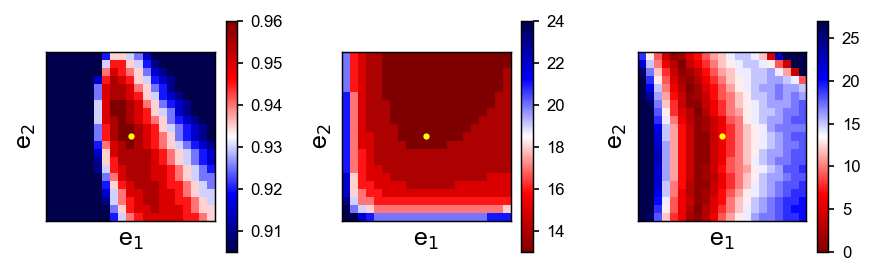

In [105]:
fig = plt.figure(figsize=(6, 2))
ax = plt.subplot(131)
im = ax.imshow(cc_eigen_mat_round[:, ::-1].T, cmap='seismic', vmin=np.nanmin(cc_eigen_mat_round)+0.88, vmax=np.nanmax(cc_eigen_mat_round), interpolation='nearest')
plt.colorbar(im)
ax.scatter([10], [10], color='yellow', linewidth=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('e$_1$')
ax.set_ylabel('e$_2$')

ax = plt.subplot(132)
im = ax.imshow(peak_eigen_mat[:, ::-1].T, cmap='seismic_r', vmin=np.nanmin(peak_eigen_mat), vmax=np.nanmax(peak_eigen_mat)-5, interpolation='nearest')
plt.colorbar(im)
ax.scatter([10], [10], color='yellow', linewidth=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('e$_1$')
ax.set_ylabel('e$_2$')

ax = plt.subplot(133)
im = ax.imshow(width_eigen_mat[:, ::-1].T, cmap='seismic_r', vmin=np.nanmin(width_eigen_mat), vmax=np.nanmax(width_eigen_mat)-1930 ,interpolation='nearest')
plt.colorbar(im)
ax.scatter([10], [10], color='yellow', linewidth=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('e$_1$')
ax.set_ylabel('e$_2$')

plt.tight_layout()

In [106]:
N = 70
N_a = 19
N_b = N - N_a
pr_one_mat = np.zeros((5, N, 5))
out_one_mat = np.zeros((5, N, 2150))
cc_one_mat = np.zeros((5, N))
peak_one_mat = np.zeros((5, N))
width_one_mat = np.zeros((5, N))
p_step_size = np.array([0.05, 0.05, 0.05, 0.05, 0.05])

for p in range(5):
    for a in range(N):
        pr_temp = (a - int(np.floor(N_a))) * p_step_size[p] * np.abs(pr_hat)
        pr_temp2 = np.zeros((5,))
        pr_temp2[p] = pr_temp[p]
        pr_one_mat[p, a, :] = pr_hat + pr_temp2
        
#p_scale = np.array([2, 2, 2, 2, 2])
#for p in range(5):
#    for a, n in enumerate(np.logspace(-2, p_scale[p], N)):
#        pr_one_mat[p, a, :] = pr_hat
#        pr_one_mat[p, a, p] *= n

In [107]:
for p in range(5):
    for a in range(N):
        uln = lnk.simulate_nonlinearity_2(smooth_1d(u[-10*2150:], 5), [pr_fix[0], pr_fix[1]])
        out = lnk.simulate_4state_2(uln, np.append(np.append(list(pr_one_mat[p, a, :5]), pr_fix[2] * pr_one_mat[p, a, 0]/pr_hat[0]), pr_fix[3] * pr_one_mat[p, a, -1]/pr_hat[-1]), np.array([state_0]))[1, -2150:] 
        if np.isnan(out[0]):
            cc_one_mat[p, a] = np.nan
            peak_one_mat[p, a] = np.nan
            width_one_mat[p, a] = np.nan
        else:
            cc_one_mat[p, a] = scipy.stats.pearsonr(smooth_1d(out[-2140:], 5), -l['y']['s_2_1ms_mm'][-2140:])[0]
            peak_one_mat[p, a] = abs(argmax(minmax(smooth_1d(out, 5))) - argmax(minmax(-l['y']['s_2_1ms_mm'])))
            width_one_mat[p, a] = abs(arghalf_width(minmax(smooth_1d(out, 5))) - arghalf_width(minmax(-l['y']['s_2_1ms_mm'])))
        if width_one_mat[p, a] > 100:
            width_one_mat[p, a] = np.nan

/Users/dlee/lnk-moving-bar/python/lnk.py:81: RuntimeWarning: invalid value encountered in add
  x_curr = x_curr + 0.001 * np.matmul(x_curr.reshape(1, 4), Q).reshape(4,)


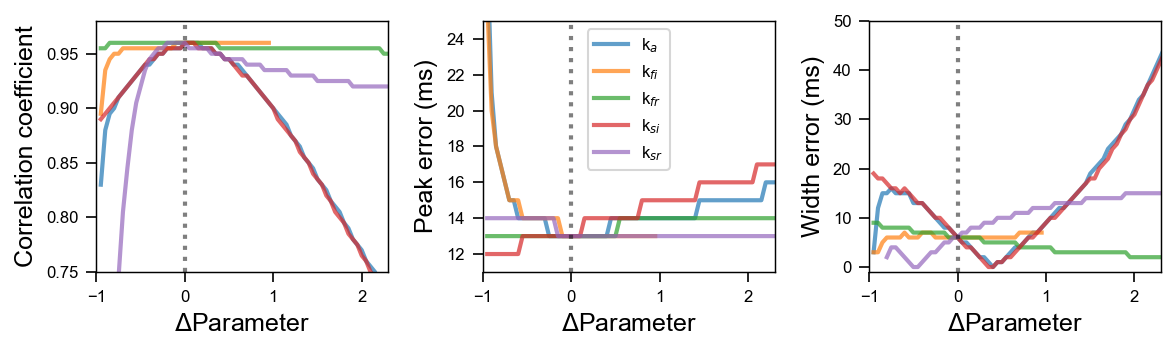

In [108]:
param_x = np.linspace(-N_a*p_step_size[0], (N-N_a-1)*p_step_size[0], N)
fig = plt.figure(figsize=(8, 2.5))

ax = plt.subplot(131)
ax.plot(param_x, np.round(200*cc_one_mat[:].T)/200, linewidth=2, alpha=0.7)
ax.axvline(x=0, linestyle=':', color='k', linewidth=2, alpha=0.5)
ax.set_xlim(-1, 2.3)
ax.set_ylim(0.75, 0.98)
ax.tick_params(size=5)
ax.set_xlabel('$\Delta$Parameter', size=12)
ax.set_ylabel('Correlation coefficient', size=12)

ax = plt.subplot(132)
ax.plot(param_x, peak_one_mat[:].T, linewidth=2, alpha=0.7)
ax.axvline(x=0, linestyle=':', color='k', linewidth=2, alpha=0.5)
ax.set_xlim(-1, 2.3)
ax.set_ylim(11, 25)
ax.tick_params(size=5)
ax.legend(['k$_{a}$', 'k$_{fi}$', 'k$_{fr}$', 'k$_{si}$', 'k$_{sr}$'], fontsize=8)
ax.set_xlabel('$\Delta$Parameter', size=12)
ax.set_ylabel('Peak error (ms)', size=12)

ax = plt.subplot(133)
ax.plot(param_x, width_one_mat[:].T, linewidth=2, alpha=0.7)
ax.axvline(x=0, linestyle=':', color='k', linewidth=2, alpha=0.5)
ax.set_xlim(-1, 2.3)
ax.set_ylim(-1, 50)
ax.tick_params(size=5)
ax.set_xlabel('$\Delta$Parameter', size=12)
ax.set_ylabel('Width error (ms)', size=12)

plt.tight_layout()

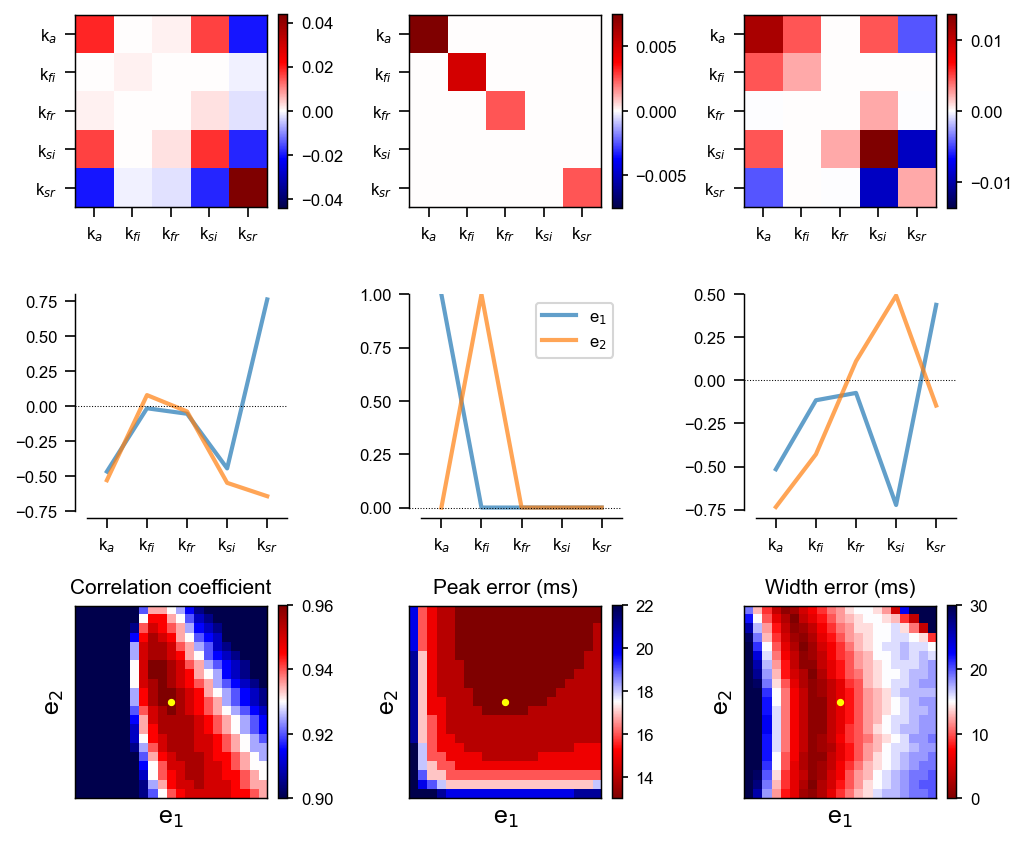

In [109]:
legend_rate = ['k$_a$', 'k$_{fi}$', 'k$_{fr}$', 'k$_{si}$', 'k$_{sr}$']

fig = plt.figure(figsize=(7, 6))

ax = plt.subplot(331)
im = ax.imshow(cc_k_hess_p, cmap='seismic', vmin=-np.max(abs(cc_k_hess_p)), vmax=np.max(abs(cc_k_hess_p)))
plt.colorbar(im, fraction=0.0455)
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = legend_rate
ax.set_yticklabels(labels)
ax.tick_params(size=5)

ax = plt.subplot(332)
im = ax.imshow(peak_k_hess_p, cmap='seismic', vmin=-np.max(abs(peak_k_hess_p)), vmax=np.max(abs(peak_k_hess_p)))
plt.colorbar(im, fraction=0.0455)
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = legend_rate
ax.set_yticklabels(labels)
ax.tick_params(size=5)

ax = plt.subplot(333)
im = ax.imshow(width_k_hess_p, cmap='seismic', vmin=-np.max(abs(width_k_hess_p)), vmax=np.max(abs(width_k_hess_p)))
plt.colorbar(im, fraction=0.0455)
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = legend_rate
ax.set_yticklabels(labels)
ax.tick_params(size=5)

ax = plt.subplot(334)
ax.plot(cc_eigenvec[:, 0], linewidth=2, alpha=0.7)
ax.plot(cc_eigenvec[:, 1], linewidth=2, alpha=0.7)
ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.8, 4.5])
ax.set_ylim([-0.8, 0.8])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 4.5)
ax.spines['left'].set_bounds(-0.75, 0.8)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))


ax = plt.subplot(335)
ax.plot(peak_eigenvec[:, 0], linewidth=2, label='e$_1$', alpha=0.7)
ax.plot(peak_eigenvec[:, 1], linewidth=2, label='e$_2$', alpha=0.7)
ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.8, 4.5])
ax.set_ylim([-0.05, 1])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 4.5)
ax.spines['left'].set_bounds(0, 1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
ax.legend(fontsize=8)

ax = plt.subplot(336)
ax.plot(width_eigenvec[:, 0], linewidth=2, alpha=0.7)
ax.plot(width_eigenvec[:, 1], linewidth=2, alpha=0.7)
ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.8, 4.5])
ax.set_ylim([-0.8, 0.5])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 4.5)
ax.spines['left'].set_bounds(-0.75, 0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))

ax = plt.subplot(337)
im = ax.imshow(cc_eigen_mat_round[:, ::-1].T, cmap='seismic', vmin=np.nanmin(cc_eigen_mat_round)+0.875, vmax=np.nanmax(cc_eigen_mat_round), interpolation='nearest')
plt.colorbar(im, fraction=0.0455)
ax.scatter([10], [10], color='yellow', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(size=5)
ax.set_xlabel('e$_1$')
ax.set_ylabel('e$_2$')
ax.set_title('Correlation coefficient', size=10)

ax = plt.subplot(338)
im = ax.imshow(peak_eigen_mat[:, ::-1].T, cmap='seismic_r', vmin=np.nanmin(peak_eigen_mat), vmax=np.nanmax(peak_eigen_mat)-7, interpolation='nearest')
plt.colorbar(im, fraction=0.0455)
ax.scatter([10], [10], color='yellow', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(size=5)
ax.set_xlabel('e$_1$')
ax.set_ylabel('e$_2$')
ax.set_title('Peak error (ms)', size=10)

ax = plt.subplot(339)
im = ax.imshow(width_eigen_mat[:, ::-1].T, cmap='seismic_r', vmin=np.nanmin(width_eigen_mat), vmax=np.nanmax(width_eigen_mat)-1927 ,interpolation='nearest')
plt.colorbar(im, fraction=0.0455)
ax.scatter([10], [10], color='yellow', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(size=5)
ax.set_xlabel('e$_1$')
ax.set_ylabel('e$_2$')
ax.set_title('Width error (ms)', size=10)

#fig.align_labels()
plt.tight_layout(h_pad=0.3, w_pad=1.4)

# suppl
#plt.savefig('fig_supp_lnk_hessian+eigenvec+heatmap.pdf', bbox_inches='tight', transparent=True, dpi=300)

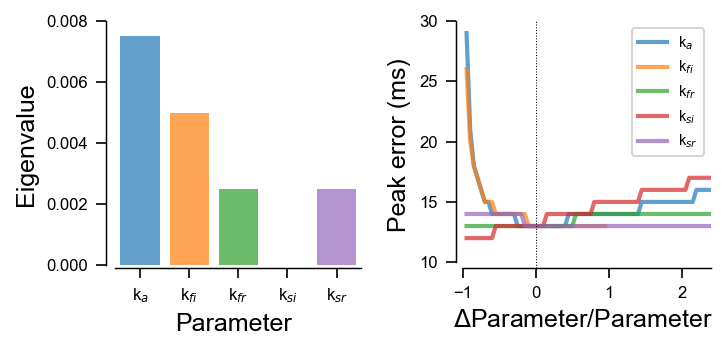

In [110]:
param_x = np.linspace(-N_a*p_step_size[0], (N-N_a-1)*p_step_size[0], N)
fig = plt.figure(figsize=(5, 2.5))

ax = plt.subplot(121)
ax.bar([0, 1, 2, 3, 4], peak_k_hess_p.diagonal(), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:5], alpha=0.7)
ax.set_xlim([-0.7, 4.5])
ax.set_ylim([-0.0001, 0.008])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 5)))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = legend_rate
ax.set_xticklabels(labels)
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 4.5)
ax.spines['left'].set_bounds(0, 0.008)
ax.set_xlabel('Parameter')
ax.set_ylabel('Eigenvalue')

ax = plt.subplot(122)
ax.plot(param_x, peak_one_mat[:].T, linewidth=2, alpha=0.7)
ax.axvline(x=0, linestyle=':', color='k', linewidth=0.5)
ax.set_xlim([-1.1, 2.4])
ax.set_ylim([9.5, 30])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-1, 2.4)
ax.spines['left'].set_bounds(10, 30)
ax.legend(['k$_{a}$', 'k$_{fi}$', 'k$_{fr}$', 'k$_{si}$', 'k$_{sr}$'], fontsize=7)
ax.set_xlabel('$\Delta$Parameter/Parameter', size=12)
ax.set_ylabel('Peak error (ms)', size=12)

plt.tight_layout()

# main
#plt.savefig('fig_lnk_eigenval+paramsweep.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [111]:
uln = lnk.simulate_nonlinearity_2(smooth_1d(u, 5), [-1.05, 5.4])
out = lnk.simulate_4state_2(uln, np.array([87, 1020, 0.43, 0.05, 4.3, 100, -9.5]), np.array([0.07, 0.04, 99.54, 0.35]))

In [112]:
np.arange(-1.075, 1.075, 0.001)

array([-1.075, -1.074, -1.073, ...,  1.072,  1.073,  1.074])

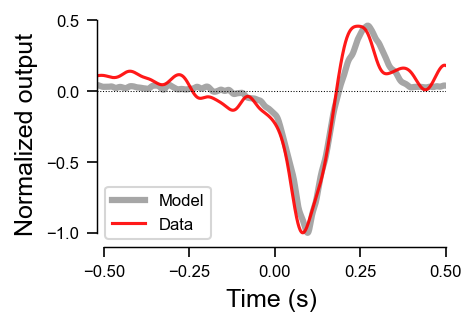

In [201]:
fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)
ax.plot(np.arange(-1.075, 1.075, 0.001), -minmax(out[1, -2150:]), color='black', linewidth=3, alpha=0.35, label='Model')
ax.plot(np.arange(-1.075, 1.075, 0.001), -minmax(-l['y']['s_2_1ms_mm']), color='red', linewidth=1.5, alpha=0.9, label='Data')
ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.52, 0.5])
#ax.set_xlim([-1.05, 1])
ax.set_ylim([-1.1, 0.5])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 0.5)
#ax.spines['bottom'].set_bounds(-1, 1)
ax.spines['left'].set_bounds(-1, 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized output')
ax.legend(fontsize=8, loc=3)

#plt.savefig('fig_lnk_data+modelfit+1s.pdf', bbox_inches='tight', transparent=True, dpi=300)

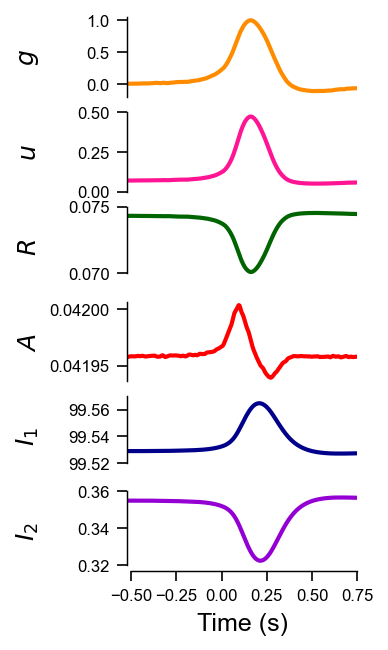

In [233]:
fig = plt.figure(figsize=(2.75, 4.5))

ax = plt.subplot(611)
ax.plot(np.arange(-1.075, 1.075, 0.001), minmax(u[-2150:]), color='darkorange', linewidth=2)
#ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.52, 0.75])
ax.set_ylim([-0.20, 1.05])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 0.75)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.50))
#ax.spines['left'].set_bounds(-0.12, 1.0)
ax.set_xticks([])
ax.set_ylabel('$g$')


ax = plt.subplot(612)
ax.plot(np.arange(-1.075, 1.075, 0.001), uln[-2150:] - 5.4, color='deeppink', linewidth=2)
#ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
ax.set_xlim([-0.52, 0.75])
ax.set_ylim([0.0, 0.5])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
#ax.spines['left'].set_bounds(0, 0.5)
ax.set_xticks([])
ax.set_ylabel('$u$')

ax = plt.subplot(613)
ax.plot(np.arange(-1.075, 1.075, 0.001), out[0, -2150:], color='darkgreen', linewidth=2)
ax.set_xlim([-0.52, 0.75])
ax.set_ylim([0.069, 0.075])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 0.75)
ax.spines['left'].set_bounds(0.07, 0.075)
ax.set_xticks([])
ax.set_ylabel('$R$')

ax = plt.subplot(614)
ax.plot(np.arange(-1.075, 1.075, 0.001), out[1, -2150:], color='red', linewidth=2)
ax.set_xlim([-0.52, 0.75])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 0.75)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=5*10e-6))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3e'))
ax.set_xticks([])
ax.set_ylabel('$A$')

ax = plt.subplot(615)
ax.plot(np.arange(-1.075, 1.075, 0.001), out[2, -2150:], color='darkblue', linewidth=2)
ax.set_xlim([-0.52, 0.75])
ax.set_ylim([99.51, 99.57])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 0.75)
ax.spines['left'].set_bounds(99.52, 99.57)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.02))
ax.set_xticks([])
ax.set_ylabel('$I_{1}$')

ax = plt.subplot(616)
ax.plot(np.arange(-1.075, 1.075, 0.001), out[3, -2150:], color='darkviolet', linewidth=2)
#ax.set_xlim([-1.05, 1])
ax.set_xlim([-0.52, 0.75])
ax.set_ylim([0.317, 0.36])
ax.tick_params(size=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(-0.5, 0.75)
#ax.spines['bottom'].set_bounds(-1, 1)
ax.spines['left'].set_bounds(0.32, 0.36)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.02))
ax.set_xlabel('Time (s)')
ax.set_ylabel('$I_{2}$')

fig.align_labels()
plt.tight_layout(h_pad=0, w_pad=0)

#plt.savefig('fig_lnk_state+occupancy+6.pdf', bbox_inches='tight', transparent=True, dpi=300)